In [1]:
import csv
import pandas as pd
import numpy as np
import time
import copy

# 保留 time 和 machine

In [2]:
input_file_path = 'tai20_15.txt'
output_file_path = 'tai20_15.csv'

# Open the input text file for reading
with open(input_file_path, 'r') as txt_file:
    lines = txt_file.readlines()

# Open the output CSV file for writing
with open(output_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    previous_csv_row = lines[0]
    for line in lines:
        csv_row = line.strip().split()
        if 'Nb' not in previous_csv_row and 'Nb' not in csv_row :
            csv_writer.writerow(csv_row)
        previous_csv_row = csv_row

print(f"Conversion from {input_file_path} to {output_file_path} complete.")

Conversion from tai20_15.txt to tai20_15.csv complete.


In [3]:
df = pd.read_csv('tai20_15.csv', names = list(range(0,15)), header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Times,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,75.0,75.0,76.0,38.0,62.0,38.0,59.0,14.0,13.0,46.0,31.0,57.0,92.0,3.0
2,67,5.0,11.0,11.0,40.0,34.0,77.0,42.0,35.0,96.0,22.0,55.0,21.0,29.0,16.0
3,22,98.0,8.0,35.0,59.0,31.0,13.0,46.0,52.0,22.0,18.0,19.0,64.0,29.0,70.0
4,99,42.0,2.0,35.0,11.0,92.0,88.0,97.0,21.0,56.0,17.0,43.0,27.0,19.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,7,15.0,13.0,3.0,8.0,6.0,9.0,14.0,12.0,10.0,1.0,4.0,5.0,2.0,11.0
416,10,6.0,15.0,11.0,13.0,2.0,5.0,14.0,1.0,12.0,4.0,3.0,8.0,7.0,9.0
417,10,13.0,5.0,15.0,12.0,9.0,1.0,8.0,6.0,4.0,2.0,11.0,7.0,14.0,3.0
418,13,3.0,4.0,15.0,6.0,2.0,7.0,12.0,14.0,10.0,8.0,11.0,9.0,1.0,5.0


# 分開 time 和 machine

In [4]:
df_time = df.iloc[1:21, :].round(0)
df_time.index = df_time.index - 1

In [5]:
df_machine = df.iloc[22:42, :].round(0)
df_machine.index = df_machine.index - 22

In [6]:
num_mc=df_time.shape[1] # number of machines
num_job=df_time.shape[0] # number of jobs
len_gene=num_mc*num_job # number of genes in a chromosome

# 設定參數

In [7]:
population_size=int(input('Please input the size of population: ') or 30) # default value is 30
crossover_rate=float(input('Please input the size of Crossover Rate: ') or 0.8) # default value is 0.8
mutation_rate=float(input('Please input the size of Mutation Rate: ') or 0.2) # default value is 0.2
mutation_selection_rate=float(input('Please input the mutation selection rate: ') or 0.2)
num_mutation_jobs=round(len_gene*mutation_selection_rate)
num_iteration=int(input('Please input number of iteration: ') or 2000) # default value is 2000

In [8]:
pt=[list(map(int, df_time.iloc[i])) for i in range(num_job)]
ms=[list(map(int,df_machine.iloc[i])) for i in range(num_job)]

# 產生初始親代

In [9]:
Tbest=999999999999999
best_list,best_obj=[],[]
population_list=[] # 母代list，長度為10
best_makespan_record = []
now_best_makespan_record = []
for i in range(population_size):
    nxm_random_num=list(np.random.permutation(len_gene)) # 產生一組染色體編碼，長度為300
    population_list.append(nxm_random_num)
    for j in range(len_gene):
        population_list[i][j]=population_list[i][j]%num_job # 染色體中每個工件都只會出現15次
start_time = time.time()

# 交配、突變

In [10]:
for n in range(num_iteration):
    Tbest_now=99999999999           
   
    '''-------- two point crossover --------'''
    parent_list=copy.deepcopy(population_list)
    offspring_list=copy.deepcopy(population_list)
    S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover
    
    for m in range(int(population_size/2)):
        crossover_prob=np.random.rand()
        if crossover_rate>=crossover_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]
            child_1=parent_1[:]
            child_2=parent_2[:]
            cutpoint=list(np.random.choice(len_gene, 2, replace=False))
            cutpoint.sort()
        
            child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
            offspring_list[S[2*m]]=child_1[:]
            offspring_list[S[2*m+1]]=child_2[:]
        
    
    '''----------repairment-------------'''
    for m in range(population_size):
        job_count={}
        larger,less=[],[] # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
        for i in range(num_job):
            if i in offspring_list[m]:
                count=offspring_list[m].count(i)
                pos=offspring_list[m].index(i)
                job_count[i]=[count,pos] # store the above two values to the job_count dictionary
            else:
                count=0
                job_count[i]=[count,0]
            if count>num_mc:
                larger.append(i)
            elif count<num_mc:
                less.append(i)
                
        for k in range(len(larger)):
            chg_job=larger[k]
            while job_count[chg_job][0]>num_mc:
                for d in range(len(less)):
                    if job_count[less[d]][0]<num_mc:                    
                        offspring_list[m][job_count[chg_job][1]]=less[d]
                        job_count[chg_job][1]=offspring_list[m].index(chg_job)
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        job_count[less[d]][0]=job_count[less[d]][0]+1                    
                    if job_count[chg_job][0]==num_mc:
                        break     
    
    '''--------mutation--------'''   
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if mutation_rate >= mutation_prob:
            m_chg=list(np.random.choice(len_gene, num_mutation_jobs, replace=False)) # chooses the position to mutation
            t_value_last=offspring_list[m][m_chg[0]] # save the value which is on the first mutation position
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last # move the value of the first mutation position to the last mutation position
  
    
    '''--------fitness value(calculate makespan)-------------'''
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) # parent and offspring chromosomes combination
    chrom_fitness,chrom_fit=[],[]
    total_fitness=0
    for m in range(population_size*2):
        j_keys=[j for j in range(num_job)]
        key_count={key:0 for key in j_keys}
        j_count={key:0 for key in j_keys}
        m_keys=[j+1 for j in range(num_mc)]
        m_count={key:0 for key in m_keys}
        
        for i in total_chromosome[m]:
            gen_t=int(pt[i][key_count[i]])
            gen_m=int(ms[i][key_count[i]])
            j_count[i]=j_count[i]+gen_t
            m_count[gen_m]=m_count[gen_m]+gen_t
            
            if m_count[gen_m]<j_count[i]:
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]:
                j_count[i]=m_count[gen_m]
            
            key_count[i]=key_count[i]+1
    
        makespan=max(j_count.values())
        chrom_fitness.append(1/makespan)
        chrom_fit.append(makespan)
        total_fitness=total_fitness+chrom_fitness[m]
    
    '''----------selection(roulette wheel approach)----------'''
    pk,qk=[],[]
    
    for i in range(population_size*2):
        pk.append(chrom_fitness[i]/total_fitness)
    for i in range(population_size*2):
        cumulative=0
        for j in range(0,i+1):
            cumulative=cumulative+pk[j]
        qk.append(cumulative)
    
    selection_rand=[np.random.rand() for i in range(population_size)]
    
    for i in range(population_size):
        if selection_rand[i]<=qk[0]:
            population_list[i]=copy.deepcopy(total_chromosome[0])
        else:
            for j in range(0,population_size*2-1):
                if selection_rand[i]>qk[j] and selection_rand[i]<=qk[j+1]:
                    population_list[i]=copy.deepcopy(total_chromosome[j+1])
                    break
    '''----------comparison----------'''
    for i in range(population_size*2):
        if chrom_fit[i]<Tbest_now:
            Tbest_now=chrom_fit[i]
            sequence_now=copy.deepcopy(total_chromosome[i])
    now_best_makespan_record.append(Tbest_now)
    if Tbest_now<=Tbest:
        Tbest=Tbest_now
        sequence_best=copy.deepcopy(sequence_now)
        
    best_makespan_record.append(Tbest)
'''----------result----------'''
print("optimal sequence",sequence_best)
print("optimal value:%f"%Tbest)
print('the elapsed time:%s'% (time.time() - start_time))

optimal sequence [4, 0, 0, 0, 4, 1, 14, 16, 7, 12, 9, 1, 9, 1, 11, 1, 7, 11, 15, 11, 11, 8, 14, 15, 6, 13, 15, 14, 6, 19, 16, 17, 8, 2, 18, 18, 16, 3, 19, 8, 18, 3, 10, 16, 7, 4, 16, 5, 2, 1, 6, 0, 6, 7, 10, 13, 3, 10, 16, 13, 18, 13, 19, 18, 14, 13, 0, 8, 0, 12, 6, 4, 11, 2, 3, 2, 15, 1, 18, 3, 15, 11, 8, 10, 2, 18, 0, 7, 8, 3, 5, 15, 12, 14, 12, 5, 16, 0, 17, 4, 6, 4, 19, 9, 16, 0, 6, 18, 18, 7, 2, 2, 16, 9, 3, 10, 14, 0, 18, 8, 14, 10, 0, 6, 8, 1, 2, 17, 11, 19, 14, 19, 17, 4, 13, 19, 13, 2, 19, 16, 7, 17, 8, 15, 8, 19, 7, 5, 6, 11, 19, 12, 9, 10, 7, 12, 9, 3, 14, 4, 8, 0, 2, 3, 18, 1, 10, 13, 0, 5, 13, 0, 10, 3, 9, 1, 4, 12, 15, 17, 5, 14, 13, 7, 1, 16, 19, 6, 5, 17, 15, 3, 12, 1, 7, 9, 1, 9, 13, 19, 7, 5, 14, 3, 9, 6, 12, 17, 10, 11, 18, 17, 4, 12, 0, 12, 16, 11, 11, 15, 14, 5, 5, 11, 18, 10, 7, 2, 2, 2, 8, 14, 1, 11, 9, 14, 5, 4, 5, 10, 3, 18, 13, 12, 7, 6, 15, 4, 6, 8, 4, 8, 9, 7, 2, 13, 15, 11, 1, 12, 17, 17, 15, 19, 15, 5, 14, 18, 1, 16, 9, 3, 16, 3, 17, 17, 6, 13, 11, 17, 10,

# 演算法收斂圖

In [11]:
import matplotlib.pyplot as plt

In [12]:
print(len(best_makespan_record))

2000


In [13]:
print(len(now_best_makespan_record))

2000


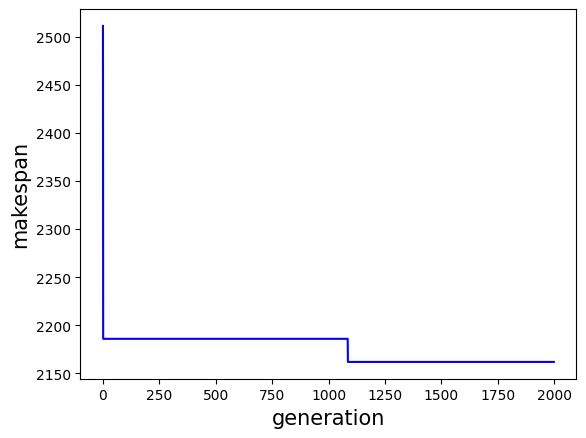

In [14]:
plt.plot([i for i in range(len(best_makespan_record))],best_makespan_record,'b')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('generation',fontsize=15)
plt.show()

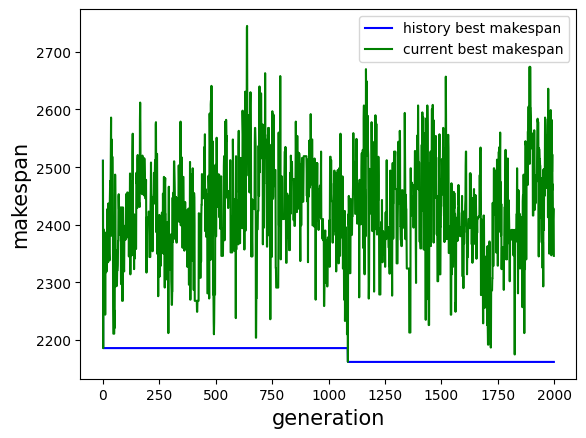

In [15]:
plt.plot([i for i in range(len(best_makespan_record))],best_makespan_record,'b', label='history best makespan')
plt.plot([i for i in range(len(now_best_makespan_record))],now_best_makespan_record,'g', label='current best makespan')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('generation',fontsize=15)
plt.legend()
plt.show()

# 甘特圖

In [19]:
import pandas as pd
from chart_studio import plotly as py
import random
import plotly.figure_factory as ff
import datetime

In [20]:
m_keys=[j+1 for j in range(num_mc)]
j_keys=[j for j in range(num_job)]
key_count={key:0 for key in j_keys}
j_count={key:0 for key in j_keys}
m_count={key:0 for key in m_keys}
j_record={}
for i in sequence_best:
    gen_t=int(pt[i][key_count[i]])
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t
    m_count[gen_m]=m_count[gen_m]+gen_t
    
    if m_count[gen_m]<j_count[i]:
        m_count[gen_m]=j_count[i]
    elif m_count[gen_m]>j_count[i]:
        j_count[i]=m_count[gen_m]
    
    start_time=str(datetime.timedelta(seconds=j_count[i]-pt[i][key_count[i]])) # convert seconds to hours, minutes and seconds
    end_time=str(datetime.timedelta(seconds=j_count[i]))
        
    j_record[(i,gen_m)]=[start_time,end_time]
    
    key_count[i]=key_count[i]+1

In [21]:
df=[]
for m in m_keys:
    for j in j_keys:
        df.append(dict(Task='Machine %s'%(m), Start='2018-07-14 %s'%(str(j_record[(j,m)][0])), Finish='2018-07-14 %s'%(str(j_record[(j,m)][1])),Resource='Job %s'%(j+1)))

In [22]:
r = lambda: random.randint(0,255)
colors = ['#%02X%02X%02X' % (r(),r(),r())]       
for i in range(1, 21):      
        colors.append('#%02X%02X%02X' % (r(),r(),r()))

In [23]:
fig = ff.create_gantt(df, colors=colors, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
fig.show()